## 기본설정 및 함수정의

#### - 목표 : 
#### 1. 분석대상지에서 분석한 탄소배출 및 흡수 요인을 바탕으로 적용대상지의 토지이용계획, 추정 교통량, 계획인구 등의 데이터를 활용해<br>용도별 탄소배출량 및 흡수량을 인공지능 기법을 활용해 추정
#### 2. 적용대상지의 기존 계획으로 추정된 탄소배출량 및 흡수량을 기준으로 미래 모빌리티 분담률 적용에 따른 탄소저감 효과를 분석하고,<br>이를 공원·녹지조성 효과(면적)로 산정
#### 3. 적용대상지인 광명시흥 공공주택지구의 미래모빌리티 도입에 따른 탄소저감 효과분석에 관한 내용을 반드시 분석 보고서에 포함
##### “DRT 운행 통계” 데이터, “광명시흥 교통수요 예측” 보고서를 활용하여 미래 모빌리티 분담률에 따른 탄소저감 효과를 자유롭게 분석하여 추정하되,<br>분석대상 모빌리티는 육상 수단만을 대상으로 함(UAM 제외)


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

In [2]:
# 송파구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_11240_2023_4Q/bnd_dong_11240_2023_4Q.shp"
songpa_gdf = gpd.read_file(shapefile_path1)
songpa_gdf = songpa_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 인천서구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_23080_2023_4Q/bnd_dong_23080_2023_4Q.shp"
incheon_seo_gdf = gpd.read_file(shapefile_path1)
incheon_seo_gdf = incheon_seo_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 성남시 수정구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31021_2023_4Q/bnd_dong_31021_2023_4Q.shp"
sungnam_soojung_gdf = gpd.read_file(shapefile_path1)
sungnam_soojung_gdf = sungnam_soojung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# # 성남시 중원구 행정동 데이터
# shapefile_path1 = "SBJ_2504_001/bnd_dong_31022_2023_4Q/bnd_dong_31022_2023_4Q.shp"
# sungnam_jungwon_gdf = gpd.read_file(shapefile_path1)
# sungnam_jungwon_gdf = sungnam_jungwon_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# # 성남시 분당구 행정동 데이터
# shapefile_path1 = "SBJ_2504_001/bnd_dong_31023_2023_4Q/bnd_dong_31023_2023_4Q.shp"
# sungnam_bundang_gdf = gpd.read_file(shapefile_path1)
# sungnam_bundang_gdf = sungnam_bundang_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#  하남시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31180_2023_4Q/bnd_dong_31180_2023_4Q.shp"
hanam_gdf = gpd.read_file(shapefile_path1)
hanam_gdf = hanam_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#  화성시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31240_2023_4Q/bnd_dong_31240_2023_4Q.shp"
hwasung_gdf = gpd.read_file(shapefile_path1)
hwasung_gdf = hwasung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 광명시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31060_2023_4Q/bnd_dong_31060_2023_4Q.shp"
gwangmyung_gdf = gpd.read_file(shapefile_path1)
gwangmyung_gdf = gwangmyung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 시흥시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31150_2023_4Q/bnd_dong_31150_2023_4Q.shp"
siheung_gdf = gpd.read_file(shapefile_path1)
siheung_gdf = siheung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 필요한 GeoDataFrame들을 리스트로 묶어서 병합
gdf_list = [
    songpa_gdf, incheon_seo_gdf, sungnam_soojung_gdf,
    hanam_gdf, hwasung_gdf, gwangmyung_gdf, siheung_gdf
]

# 하나의 GeoDataFrame으로 통합
merged_area_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs="EPSG:4326")

##### 적용대상지 격자

In [71]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/10. 격자(적용대상지).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_apply = pd.json_normalize(geojson_data['features'])
grid_apply['geometry'] = grid_apply['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_apply.drop(columns="geometry.coordinates", axis=1, inplace=True)
# grid_apply 데이터프레임을 GeoDataFrame으로 변환
grid_apply = gpd.GeoDataFrame(grid_apply, geometry='geometry')
grid_apply_dict = dict(zip(grid_apply['properties.gid'], grid_apply['geometry']))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type']
grid_apply = grid_apply.drop(columns=drop_cols)

# 'properties.' 접두사 제거
grid_apply.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in grid_apply.columns
]

grid_apply = grid_apply.drop_duplicates(subset='gid', keep='first')

# 격자와 도시공간의 공간 교차
grid_apply = gpd.sjoin(grid_apply, merged_area_gdf, how='inner', predicate='intersects')

# 필요 없는 열 제거 (sjoin 결과에는 index_right 등 추가됨)
grid_apply = grid_apply.drop(columns=["index_right"])
grid_apply = grid_apply.drop_duplicates(['gid'], keep='last')
grid_apply = grid_apply[['gbn', 'gid', 'geometry', 'zoneName']].reset_index(drop=True)

C:\Users\user\AppData\Local\Temp\ipykernel_10032\3177832267.py:24: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326




In [ ]:
# 맵 객체 생성 및 데이터 로드
grid_map = KeplerGl(height=1000, width=1500)
grid_map.add_data(data=grid_apply, name="격자 데이터")
grid_map.add_data(data=gwangmyung_gdf, name="광명 데이터")
grid_map.add_data(data=siheung_gdf, name="시흥 데이터")

# 맵 출력 및 상세설정
grid_map

In [ ]:
# 맵 저장
# grid_map.save_to_html(file_name="시각화/분석대상지.html")

Map saved to 시각화/분석대상지.html!


#### 토지이용계획도

In [83]:
areaplan = gpd.read_file('SBJ_2504_001/11._토지이용계획도.geojson', encoding='euc-kr')
areaplan = gpd.GeoDataFrame(areaplan, geometry='geometry')
areaplan = areaplan[['zoneName', 'blockName', 'blockType', 'geometry']]

# 분석대상 & 적용대상 구분
areaplan_analysis = areaplan[areaplan['zoneName']!='광명시흥 공공주택지구']
areaplan_analysis.loc[areaplan_analysis['blockName'] == 'D42', ['blockName', 'blockType']] = ['도', '도로']
gwangmyeong_siheung = areaplan[areaplan['zoneName']=='광명시흥 공공주택지구']

# 엑셀 파일 불러오기
plan_info = pd.read_excel("SBJ_2504_001/26. (참고자료) 토지이용_구역별계획.xlsx")

groupings = {
    "1": ["D2-1", "D2-2"],  # 건설호수 96, 인구 239
    "2": ["D1-1", "D1-2", "D1-3", "D1-4", "D1-5", "D1-6", "D1-7", "D1-8", "D1-9", "D1-10", "D1-11", "D1-12", "D1-13", "D1-14",
          "D2-3", "D2-4", "D2-5", "D2-6", "D2-7", "D2-8", "D2-9", "D2-10", "D2-11"],  # 971, 2428
    "3": ["BD1-1", "BD1-2", "BD2-1", "BD2-2"],  # 건설호수 161, 인구 403
}
group_values = {
    "1": {"건설호수": 96, "인구": 239},
    "2": {"건설호수": 971, "인구": 2428},
    "3": {"건설호수": 161, "인구": 403},
}

# 엑셀 데이터에 건설호수/인구 배분
plan_info["건설호수_추정"] = None
plan_info["인구_추정"] = None

for group, zones in groupings.items():
    if group not in group_values:
        continue  # 값 없는 그룹은 생략

    subset = plan_info[plan_info["구역"].isin(zones)].copy()
    total_area = subset["면적"].sum()
    if total_area == 0:
        continue

    # 비율 계산
    area_ratio = subset["면적"] / total_area
    plan_info.loc[plan_info["구역"].isin(zones), "건설호수_추정"] = (area_ratio * group_values[group]["건설호수"]).round().astype("Int64")
    plan_info.loc[plan_info["구역"].isin(zones), "인구_추정"] = (area_ratio * group_values[group]["인구"]).round().astype("Int64")

# 기존 코드 이후에 이 블록만 추가
for group, zones in groupings.items():
    if group not in group_values:
        continue  # 값이 없는 그룹은 생략

    # 건설호수_추정 → 건설호수, 인구_추정 → 인구
    plan_info.loc[plan_info["구역"].isin(zones), "건설호수"] = plan_info.loc[plan_info["구역"].isin(zones), "건설호수_추정"]
    plan_info.loc[plan_info["구역"].isin(zones), "인구"] = plan_info.loc[plan_info["구역"].isin(zones), "인구_추정"]

# 필요한 열만 선택
columns_to_merge = ['구역', '면적', '건설호수', '인구', '주택유형']
plan_info = plan_info[columns_to_merge]

# 병합 수행 ('blockName' <-> '구역' 기준, left join으로 기존 areaplan_target에 추가 열 붙이기)
gwangmyeong_siheung = gwangmyeong_siheung.merge(plan_info, how='left', left_on='blockName', right_on='구역')
gwangmyeong_siheung['건설호수'] = gwangmyeong_siheung['건설호수'].astype('Int64')
gwangmyeong_siheung['인구'] = gwangmyeong_siheung['인구'].astype('Int64')

# 불필요한 '구역' 열 제거 (원하는 경우)
gwangmyeong_siheung.drop(columns='구역', inplace=True)

In [84]:
dongtan = areaplan_analysis[(areaplan_analysis['zoneName'] == '화성동탄지구 택지개발사업')|(areaplan_analysis['zoneName'] == '화성동탄2지구 택지개발예정지구')]
dongtan_polygon = unary_union(dongtan.geometry)

wirye = areaplan_analysis[areaplan_analysis['zoneName'] == '위례 택지개발사업 개발계획']
wirye_polygon = unary_union(wirye.geometry)

cheongna = areaplan_analysis[areaplan_analysis['zoneName'] == '인천경제자유구역 청라국제도시']
cheongna_polygon = unary_union(cheongna.geometry)

misa = areaplan_analysis[areaplan_analysis['zoneName'] == '하남미사 공공주택지구 조성사업']
misa_polygon = unary_union(misa.geometry)

gwangmyeong_siheung_polygon = unary_union(gwangmyeong_siheung.geometry)

# 필요한 GeoDataFrame들을 리스트로 묶어서 병합
gdf_list = [
    dongtan, wirye, cheongna,
    misa, gwangmyeong_siheung
]

# 하나의 GeoDataFrame으로 통합
merged_area_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs="EPSG:4326")
merged_area_gdf = merged_area_gdf[['zoneName','blockType','geometry']] # ,'blockType'

# blockType → 카테고리로 매핑할 사전 정의
blocktype_mapping = {
    '공동주택': ['아파트', '공동주택', '연립주택', '다세대주택'],
    '상업': ['근린상업', '일반상업', '중심상업', '상업시설', '주상복합'],
    '산업': ['산업용지', '산업시설기타', '투자유치용지'],
    '공원': ['공원', '도시공원', '문화공원', '근린공원', '공원기타'],
    '녹지': ['녹지', '완충녹지', '녹지시설', '연결녹지'],
    '단독주택': ['단독주택'],
    '도로': ['도로', '교통광장', '보행자전용도로'],
    '하천': ['하천', '수로', '저수지']
}

# 역매핑 딕셔너리 생성
reverse_mapping = {}
for category, subtypes in blocktype_mapping.items():
    for subtype in subtypes:
        reverse_mapping[subtype] = category

# 기존 blockType을 통합된 카테고리로 재분류
merged_area_gdf['blockType'] = merged_area_gdf['blockType'].map(reverse_mapping)
merged_area_gdf['blockType'] = merged_area_gdf['blockType'].fillna('기타')

#### 격자에 토지 이용계획 반영

In [85]:
#### 격자에 토지 이용계획 반영
# 좌표계 설정
merged_area_gdf = merged_area_gdf.set_crs(epsg=4326)
grid_apply = grid_apply.set_crs(epsg=4326)

# 면적 계산을 위해 투영 (면적 단위: m²)
merged_proj = merged_area_gdf.to_crs(5179)
grid_proj = grid_apply.to_crs(5179)

# blockType별 전체 면적 계산 → 상위 N개 추출
merged_proj['area'] = merged_proj.geometry.area
top_types = (
    merged_proj.groupby('blockType')['area'].sum()
    .sort_values(ascending=False)
    .head(10)  # 상위 선택
    .index.tolist()
)

# blockType 분류 (기타 포함)
merged_proj['blockType_grp'] = np.where(
    merged_proj['blockType'].isin(top_types),
    merged_proj['blockType'],
    '기타'
)

# 격자와 blockType 교차 → 면적 계산
inter = gpd.overlay(grid_proj[['gid', 'geometry']],
                    merged_proj[['blockType_grp', 'geometry']],
                    how='intersection')

inter['intersect_area'] = inter.geometry.area

# 격자별 blockType 면적 집계 (pivot)
pivot = (
    inter.groupby(['gid', 'blockType_grp'])['intersect_area']
    .sum()
    .reset_index()
    .pivot(index='gid', columns='blockType_grp', values='intersect_area')
    .fillna(0)
)

# 비율(%)로 정규화
pivot['total'] = pivot.sum(axis=1)
ratio_df = pivot.div(pivot['total'], axis=0).drop(columns='total')

# 원래 grid_apply에 병합
grid_apply = grid_apply.merge(ratio_df, on='gid', how='left')


In [7]:
gwangmyeong_siheung

,zoneName,blockName,blockType,geometry,면적,건설호수,인구,주택유형
0,광명시흥 공공주택지구,D1-8,단독주택,"POLYGON Z ((126.85151 37.46435 0.00000, 126.85...",4331,15,38,NaN
1,광명시흥 공공주택지구,공원,공원,"POLYGON Z ((126.84738 37.46431 0.00000, 126.84...",1719442,<NA>,<NA>,NaN
2,광명시흥 공공주택지구,D1-8,단독주택,"POLYGON Z ((126.85095 37.46436 0.00000, 126.85...",4331,15,38,NaN
3,광명시흥 공공주택지구,A1-2,공동주택,"POLYGON Z ((126.84217 37.47100 0.00000, 126.84...",28684,689,1722,공공분양
4,광명시흥 공공주택지구,공원,공원,"POLYGON Z ((126.84172 37.44770 0.00000, 126.84...",1719442,<NA>,<NA>,NaN
...,...,...,...,...,...,...,...,...
1042,광명시흥 공공주택지구,공원,공원,"POLYGON Z ((126.82990 37.45127 0.00000, 126.83...",1719442,<NA>,<NA>,NaN
1043,광명시흥 공공주택지구,D1-10,단독주택,"POLYGON Z ((126.84922 37.44640 0.00000, 126.84...",22884,80,200,NaN
1044,광명시흥 공공주택지구,D1-10,단독주택,"POLYGON Z ((126.84926 37.44719 0.00000, 126.84...",22884,80,200,NaN
1045,광명시흥 공공주택지구,고4,교육시설,"POLYGON Z ((126.83449 37.44485 0.00000, 126.83...",14400,<NA>,<NA>,NaN


#### 격자에 인구 추정 및 매핑

In [86]:
# 좌표계 확인 및 설정
grid_apply = grid_apply.set_crs(epsg=4326)
gwangmyeong_siheung = gwangmyeong_siheung.set_crs(epsg=4326)

# 거리 단위 계산 위해 투영 좌표계로 변환 (EPSG:5179)
grid_proj = grid_apply.to_crs(5179)
block_proj = gwangmyeong_siheung.to_crs(5179)

# 인구가 결측이 아닌 블록만 사용
block_proj = block_proj.dropna(subset=['인구'])

# 교차 (격자-블록)
inter = gpd.overlay(grid_proj[['gid', 'geometry']], block_proj[['geometry', '인구']], how='intersection')

# 면적 비율 계산
inter['intersect_area'] = inter.geometry.area
inter['block_area'] = inter.geometry.apply(lambda g: block_proj.loc[block_proj.intersects(g), 'geometry'].area.values[0])
inter['인구기여'] = inter['인구'] * (inter['intersect_area'] / inter['block_area'])

# 격자별 인구 합산
pop_by_grid = inter.groupby('gid')['인구기여'].sum().reset_index().rename(columns={'인구기여': '거주인구'})

# 원래 grid_apply에 병합
grid_apply = grid_apply.merge(pop_by_grid, on='gid', how='left')

# 결측값은 0으로 처리
grid_apply['거주인구'] = grid_apply['거주인구'].fillna(0).round(1)

#### 교차로 추정교통량

In [87]:
e_crossroad_2032 = gpd.read_file('SBJ_2504_001/24. 교차로_추정교통량_2032.geojson', encoding='euc-kr')
e_crossroad_2032 = gpd.GeoDataFrame(e_crossroad_2032, geometry='geometry')

e_crossroad_2036 = gpd.read_file('SBJ_2504_001/25. 교차로_추정교통량_2036.geojson', encoding='euc-kr')
e_crossroad_2036 = gpd.GeoDataFrame(e_crossroad_2036, geometry='geometry')

#### 회귀 활용한 보간을 위해 분석대상지 데이터 가져오기

In [88]:
grid_result = pd.read_csv("분석대상지.csv")

In [27]:
grid_result

,구분,gid,geometry,공동주택,상업,산업,공원,녹지,단독주택,도로,하천,기타,거주인구,유동인구,dist_to_hotspot_km,사업체당종사자수,지가경쟁력,녹지면적,탄소흡수량,탄소배출량(수송),ALL_AADT,PSCR_AADT,BUS_AADT,FGCR_AADT,혼잡빈도강도,혼잡시간강도,평균속도,가중혼잡도,탄소배출량(통합)
0,동탄신도시,다사599119,POLYGON ((127.04810191956149 37.20504793370874...,0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.655922,1.085180,0.000000,0.251135,8943.435248,22.314729,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,동탄신도시,다사599120,POLYGON ((127.04809654505836 37.20594931725529...,0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.148192,1.049590,0.000000,0.320358,9977.773849,28.262768,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,동탄신도시,다사599121,"POLYGON ((127.048091170316 37.20685070066367, ...",0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,6.296741,1.022583,0.000000,0.320358,8435.691755,29.009220,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,동탄신도시,다사599122,"POLYGON ((127.04808579533442 37.2077520839339,...",0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,7.293541,1.004853,0.000000,0.000000,6928.062708,23.893586,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,동탄신도시,다사599123,POLYGON ((127.04808042011362 37.20865346706596...,0.08897,0.0,0.0,0.655231,0.0,0.0,0.255799,0.000000,0.000000,6.230481,7.872230,0.996894,1.335001,0.943359,760.423706,2.623352,16.616245,6660.399,5454.216,379.293,826.891,63.377,84.092,20.546,2.775,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6958,청라국제도시,다사259492,POLYGON ((126.66124027553555 37.53914794767928...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,6.499742,0.537301,0.000000,0.420243,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6959,청라국제도시,다사260488,POLYGON ((126.66241242071472 37.53555092426475...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.993454,0.006546,0.000000,5.157733,0.534879,0.000000,0.108471,0.000000,0.000000,137.607757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6960,청라국제도시,다사260489,POLYGON ((126.66240233973959 37.53645218886034...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,6.270175,0.529809,0.000000,0.305530,0.000000,0.000000,137.607757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6961,청라국제도시,다사260490,POLYGON ((126.66239225831542 37.53735345331574...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,6.668482,0.543427,0.000000,0.229228,0.000000,0.000000,137.636707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


#### 격자에 사업체 당 종사자수 예측 및 매핑

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# 1. 입력 변수 정의 (공동주택 ~ 거주인구까지)
feature_cols = ['공동주택', '공원', '기타', '녹지', '단독주택', '도로', '상업', '하천', '거주인구']

# 2. 학습용 데이터 준비 (grid_result: 사업체당종사자수 있는 행만)
train_df = grid_result.dropna(subset=['사업체당종사자수'])  # 사업체당종사자수 값 있는 행만 사용
X_train = train_df[feature_cols]
y_train = train_df['사업체당종사자수']

# 3. 예측용 데이터 준비 (grid_apply)
X_pred = grid_apply[feature_cols]

# 4. 모델 학습 및 예측
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predicted_flow = model.predict(X_pred)

# 5. 예측값 삽입
grid_apply['사업체당종사자수'] = predicted_flow.round(1)


#### 교통량 예측 및 매핑

In [90]:
from sklearn.ensemble import RandomForestRegressor
# Step 1: 교차로 Point → 격자에 TOTAL 매핑 (단순 포함 기반)
e_crossroad_2032 = e_crossroad_2032.set_crs(4326)
grid_apply = grid_apply.set_crs(4326)

crossroad_gdf = e_crossroad_2032[['geometry', 'TOTAL']].dropna()

# Point 포함된 격자에 TOTAL 합산
joined = gpd.sjoin(crossroad_gdf, grid_apply[['gid', 'geometry']], how='inner', predicate='within')
crossroad_sum = joined.groupby('gid')['TOTAL'].sum().reset_index().rename(columns={'TOTAL': 'point_ALL_AADT'})

# grid_apply에 반영
grid_apply = grid_apply.merge(crossroad_sum, on='gid', how='left')
grid_apply['point_ALL_AADT'] = grid_apply['point_ALL_AADT'].fillna(0)

# Step 2: 머신러닝 예측 기반 ALL_AADT 계산
feature_cols = ['공동주택', '공원', '기타', '녹지', '단독주택', '도로', '상업', '하천', '거주인구']

train_df = grid_result.dropna(subset=['ALL_AADT'])
X_train = train_df[feature_cols]
y_train = train_df['ALL_AADT']

X_pred = grid_apply[feature_cols]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predicted_flow = model.predict(X_pred)

# Step 3: 예측값 + 교차로 반영값 → 선형 조합
combined_flow = predicted_flow + grid_apply['point_ALL_AADT']

# Step 4: 도로 비율에 따라 선형 조정
road_mean = grid_apply['도로'].mean()
correction_factor = grid_apply['도로'] / road_mean

final_all_aadt = combined_flow * correction_factor

# 최종 반영
grid_apply['ALL_AADT'] = final_all_aadt.round(1)
grid_apply.drop(columns=['point_ALL_AADT'], inplace=True)

#### 유동인구 예측 및 매핑

In [91]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 1. 입력 변수 정의
feature_cols = ['공동주택', '공원', '기타', '녹지', '단독주택', '도로', '상업', '하천', '거주인구', 'ALL_AADT']

# 2. 학습 데이터 준비
train_df = grid_result.dropna(subset=['유동인구'])
X_train = train_df[feature_cols].fillna(0)
y_train = train_df['유동인구']

# 3. 예측 대상 데이터
X_pred = grid_apply[feature_cols].fillna(0)

# 4. 모델 학습 및 예측
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predicted_flow = model.predict(X_pred)

# 5. '상업' 비율 기반 보정 (완화 적용)
commercial_mean = grid_apply['상업'].mean()
alpha = 0.8  # 조정 강도 (0.5~0.8 권장)
adjust_factor = (grid_apply['상업'] / commercial_mean).clip(lower=0.5, upper=2.0) ** alpha

# 조정 적용
corrected_flow = predicted_flow * adjust_factor

# 6. 결과 반영
grid_apply['유동인구'] = corrected_flow.round(1)

#### 가중혼잡도 예측 및 매핑

In [92]:
from sklearn.ensemble import RandomForestRegressor

# 1. 입력 변수 정의 (공동주택 ~ 거주인구까지)
feature_cols = ['공동주택', '공원', '기타', '녹지', '단독주택', '도로', '상업', '하천', '거주인구', '유동인구', 'ALL_AADT', '사업체당종사자수']

# 2. 학습용 데이터 준비 (grid_result: 가중혼잡도 있는 행만)
train_df = grid_result.dropna(subset=['가중혼잡도'])  # 가중혼잡도 값 있는 행만 사용
X_train = train_df[feature_cols].fillna(0)
y_train = train_df['가중혼잡도']

# 3. 예측용 데이터 준비 (grid_apply)
X_pred = grid_apply[feature_cols]

# 4. 모델 학습 및 예측
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predicted_flow = model.predict(X_pred)

# 5. 예측값 삽입
grid_apply['가중혼잡도'] = predicted_flow.round(1)


#### 녹지면적 예측 및 매핑

In [93]:
from sklearn.ensemble import RandomForestRegressor

# 1. 입력 변수 정의 (공동주택 ~ 거주인구까지)
feature_cols = ['공동주택', '공원', '기타', '녹지', '단독주택', '도로', '상업', '하천', '거주인구', '유동인구', 'ALL_AADT', '사업체당종사자수']

# 2. 학습용 데이터 준비 (grid_result: 녹지면적 있는 행만)
train_df = grid_result.dropna(subset=['녹지면적'])  # 녹지면적 값 있는 행만 사용
X_train = train_df[feature_cols].fillna(0)
y_train = train_df['녹지면적']

# 3. 예측용 데이터 준비 (grid_apply)
X_pred = grid_apply[feature_cols]

# 4. 모델 학습 및 예측
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predicted_flow = model.predict(X_pred)

# 5. 예측값 삽입
grid_apply['녹지면적'] = predicted_flow.round(1)

#### 모델 예측 수행

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 예측 설정 목록
targets = {
    '탄소배출량(통합)': ['거주인구', '유동인구', '사업체당종사자수', '단독주택'],
    '탄소배출량(수송)': ['ALL_AADT', '가중혼잡도', '도로'],
    '탄소흡수량': ['녹지면적']
}

# 모델 정의
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0)
}

results = []

for target, features in targets.items():
    df = grid_result[features + [target]].copy().dropna()

    # ✅ 이상값 제거는 '탄소배출량(통합)'만 수행
    if target == '탄소배출량(통합)':
        for var in features:
            df = df[~((df[var] == 0) & (df[target] > 0))]

    # 학습/테스트 분할
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 정규화 (선형모델만 사용)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for model_name, model in models.items():
        if model_name in ['Linear Regression', 'Ridge Regression']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Target': target,
            'Model': model_name,
            'MAE': round(mae, 3),
            'RMSE': round(rmse, 3),
            'R2': round(r2, 3)
        })

# 결과 출력
results_df = pd.DataFrame(results).sort_values(by=['Target', 'RMSE'])

In [95]:
results_df

,Target,Model,MAE,RMSE,R2
6,탄소배출량(수송),Random Forest,65.643,134.381,0.622
7,탄소배출량(수송),XGBoost,67.177,135.343,0.616
4,탄소배출량(수송),Linear Regression,83.076,149.568,0.531
5,탄소배출량(수송),Ridge Regression,83.072,149.573,0.531
2,탄소배출량(통합),Random Forest,17.294,111.708,0.399
3,탄소배출량(통합),XGBoost,17.069,112.213,0.393
1,탄소배출량(통합),Ridge Regression,38.656,130.686,0.177
0,탄소배출량(통합),Linear Regression,38.658,130.687,0.177
8,탄소흡수량,Linear Regression,0.396,1.423,0.934
9,탄소흡수량,Ridge Regression,0.397,1.423,0.934


In [96]:
# ✅ 예측 결과 삽입: grid_apply에 예측값 추가
predicted_values = {}

for target, features in targets.items():
    df = grid_result[features + [target]].copy().dropna()

    # 이상값 제거 (통합만)
    if target == '탄소배출량(통합)':
        for var in features:
            df = df[~((df[var] == 0) & (df[target] > 0))]

    X_train = df[features]
    y_train = df[target]

    # 예측 대상 데이터 준비
    X_pred = grid_apply[features].copy()

    # 표준화
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_pred_scaled = scaler.transform(X_pred)

    # ✅ 가장 좋은 모델 선택 (RMSE 기준)
    best_model_name = results_df[results_df['Target'] == target].sort_values('RMSE').iloc[0]['Model']
    best_model = models[best_model_name]

    # 모델 학습 및 예측
    if best_model_name in ['Linear Regression', 'Ridge Regression']:
        best_model.fit(X_train_scaled, y_train)
        y_pred = best_model.predict(X_pred_scaled)
    else:
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_pred)

    # 결과 저장
    col_name = f'예측_{target}'
    grid_apply[col_name] = np.round(y_pred, 2)
    predicted_values[target] = y_pred

In [107]:
grid_result

,구분,gid,geometry,공동주택,상업,산업,공원,녹지,단독주택,도로,하천,기타,거주인구,유동인구,dist_to_hotspot_km,사업체당종사자수,지가경쟁력,녹지면적,탄소흡수량,탄소배출량(수송),ALL_AADT,PSCR_AADT,BUS_AADT,FGCR_AADT,혼잡빈도강도,혼잡시간강도,평균속도,가중혼잡도,탄소배출량(통합)
0,동탄신도시,다사599119,POLYGON ((127.04810191956149 37.20504793370874...,0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.655922,1.085180,0.000000,0.251135,8943.435248,22.314729,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,동탄신도시,다사599120,POLYGON ((127.04809654505836 37.20594931725529...,0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.148192,1.049590,0.000000,0.320358,9977.773849,28.262768,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,동탄신도시,다사599121,"POLYGON ((127.048091170316 37.20685070066367, ...",0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,6.296741,1.022583,0.000000,0.320358,8435.691755,29.009220,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,동탄신도시,다사599122,"POLYGON ((127.04808579533442 37.2077520839339,...",0.00000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,7.293541,1.004853,0.000000,0.000000,6928.062708,23.893586,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,동탄신도시,다사599123,POLYGON ((127.04808042011362 37.20865346706596...,0.08897,0.0,0.0,0.655231,0.0,0.0,0.255799,0.000000,0.000000,6.230481,7.872230,0.996894,1.335001,0.943359,760.423706,2.623352,16.616245,6660.399,5454.216,379.293,826.891,63.377,84.092,20.546,2.775,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6958,청라국제도시,다사259492,POLYGON ((126.66124027553555 37.53914794767928...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,6.499742,0.537301,0.000000,0.420243,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6959,청라국제도시,다사260488,POLYGON ((126.66241242071472 37.53555092426475...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.993454,0.006546,0.000000,5.157733,0.534879,0.000000,0.108471,0.000000,0.000000,137.607757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6960,청라국제도시,다사260489,POLYGON ((126.66240233973959 37.53645218886034...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,6.270175,0.529809,0.000000,0.305530,0.000000,0.000000,137.607757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6961,청라국제도시,다사260490,POLYGON ((126.66239225831542 37.53735345331574...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,6.668482,0.543427,0.000000,0.229228,0.000000,0.000000,137.636707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
# 맵 객체 생성 및 데이터 로드
areaplan_map = KeplerGl(height=1000, width=1500)
areaplan_map.add_data(data=grid_apply, name="격자 데이터")
areaplan_map.add_data(data=gwangmyeong_siheung, name="토지이용계획 데이터")

# 맵 출력 및 상세설정
areaplan_map

In [103]:
import numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# 1) 설명변수
land_cols = ['공동주택','공원','기타','녹지','단독주택','도로','상업','하천']
X_full = grid_apply[land_cols].astype(float).values
X_full = sm.add_constant(X_full, has_constant='add')[:,1:]   # 절편 제거용 add→ slicing

# 2) 면적(㎡)  + 0-division 방지
area_m2 = grid_apply.geometry.to_crs(5179).area.values
area_m2 = np.where(area_m2 < 1, 1, area_m2)   # 최소 1 ㎡

# 3) 로그예측 → 역변환 (+ clip으로 overflow 방지)
def back_transform(log_series):
    log_clipped = log_series.clip(upper=20)          # exp(20) ≈ 4.9e8
    return np.expm1(log_clipped)                     # kg CO₂/격자

y_tot = back_transform(grid_apply['예측_탄소배출량(통합)']) / area_m2
y_trn = back_transform(grid_apply['예측_탄소배출량(수송)'])  / area_m2
y_abs = back_transform(grid_apply['예측_탄소흡수량'])       / area_m2

# 4) 무한대·NaN 제거
def valid_xy(X, y):
    mask = np.isfinite(y)
    return X[mask], y[mask]

X_tot, y_tot = valid_xy(X_full, y_tot)
X_trn, y_trn = valid_xy(X_full, y_trn)
X_abs, y_abs = valid_xy(X_full, y_abs)

# 5) NNLS 회귀 (계수 ≥ 0, 절편=0)
nnls = LinearRegression(fit_intercept=False, positive=True)

β_tot = nnls.fit(X_tot, y_tot).coef_.round(5)
β_trn = nnls.fit(X_trn, y_trn).coef_.round(5)
β_abs = nnls.fit(X_abs, y_abs).coef_.round(5)

coef_tbl = pd.DataFrame({
    '토지유형': land_cols,
    '1㎡당 배출(통합)': β_tot,
    '1㎡당 배출(수송)': β_trn,
    '1㎡당 흡수량':     β_abs
})
print(coef_tbl)


   토지유형    1㎡당 배출(통합)   1㎡당 배출(수송)      1㎡당 흡수량
0  공동주택    1745.74181   8996.25958      0.00000
1    공원    3868.37596  32304.93725  23411.00447
2    기타    2496.84418  15038.37102      0.00000
3    녹지     555.27799   8076.44370  24775.77049
4  단독주택  122440.51516  40005.07550      0.00000
5    도로    5563.78995  75415.68722      0.00000
6    상업   56323.70601  24241.41600      0.00000
7    하천    3091.64784   2966.64253      0.00000


In [104]:
coef_tbl

,토지유형,1㎡당 배출(통합),1㎡당 배출(수송),1㎡당 흡수량
0,공동주택,1745.74181,8996.25958,0.00000
1,공원,3868.37596,32304.93725,23411.00447
2,기타,2496.84418,15038.37102,0.00000
3,녹지,555.27799,8076.44370,24775.77049
4,단독주택,122440.51516,40005.07550,0.00000
5,도로,5563.78995,75415.68722,0.00000
6,상업,56323.70601,24241.41600,0.00000
7,하천,3091.64784,2966.64253,0.00000


In [ ]:
coef_tbl.to_csv("토지이용계획별 1㎡당 탄소배출 및 흡수량.csv", index=False)

In [119]:
grid_apply.to_csv("적용대상지.csv", index=False)

In [124]:
from shapely import wkt
apply = pd.read_csv("적용대상지.csv") 
apply['geometry'] = apply['geometry'].apply(wkt.loads)

In [156]:
import pandas as pd, geopandas as gpd
from shapely import wkt

def csv_to_gdf(path, crs="EPSG:4326"):
    """
    CSV → GeoDataFrame 변환 (geometry 열 중복 자동 처리)
    """
    df = pd.read_csv(path)

    # 1) geometry 계열 열 파악
    g_cols = [c for c in df.columns if c.lower().startswith('geometry')]

    if len(g_cols) == 0:
        raise ValueError("geometry 열이 없습니다 - 경위도 또는 WKT 컬럼명을 확인하세요.")

    # 2) 가장 왼쪽 geometry 열만 유지, 나머지 삭제
    geom_col = g_cols[0]
    if len(g_cols) > 1:
        df = df.drop(columns=g_cols[1:])

    # 3) WKT 문자열이면 shapely 로 변환
    if df[geom_col].dtype == object:
        df[geom_col] = df[geom_col].apply(wkt.loads)

    # 4) GeoDataFrame 생성 (geometry 인수는 단 하나)
    gdf = gpd.GeoDataFrame(df, geometry=geom_col, crs=crs)
    return gdf

# 사용 예시
apply  = csv_to_gdf("적용대상지.csv")      # geometry 중복 안전 처리
test   = csv_to_gdf("분석대상지.csv")

e_crossroad_2032  = gpd.read_file("SBJ_2504_001/24. 교차로_추정교통량_2032.geojson")
e_crossroad_2036  = gpd.read_file("SBJ_2504_001/25. 교차로_추정교통량_2036.geojson")

# 1. 교차로 통행량 → 격자 매핑 (2032, 2036) -------------------------------
for cr, tag in [(e_crossroad_2032, '32'), (e_crossroad_2036, '36')]:
    join = gpd.sjoin(cr, apply[['gid', 'geometry']], how='left', predicate='within')
    sums = join.groupby('gid')['TOTAL'].sum().rename(f'TOTAL{tag}')
    apply = apply.join(sums, on='gid')

# 2. 증감율 & 수송배출 변화 -----------------------------------------------
EF = 0.18 / 1000   # t CO₂ / 승용차통행
apply['growth_%']   = (apply['TOTAL36'] - apply['TOTAL32']) / apply['TOTAL32']
apply['Δ배출(t/일)'] = (apply['TOTAL36'] - apply['TOTAL32']) * EF

# 3. 시나리오 1 (승용차 20 %) 감축량 분배 -------------------------------
total_trip_36 = e_crossroad_2036['TOTAL'].sum()
Δ_CO2 = (0.33 - 0.20) * total_trip_36 * EF
apply['도로가중']   = apply['도로'] / apply['도로'].sum()
apply['시나리오1_감축'] = apply['도로가중'] * Δ_CO2   # t/일

# 4. 1 ㎡당 흡수계수 NNLS & 100 ha 추가녹지 ---------------------------
land_cols = ['공원','녹지','도로','공동주택','단독주택','상업','기타','하천']
X = apply[land_cols].values
y_abs = np.expm1(apply['예측_탄소흡수량']) / apply.to_crs(5179).geometry.area
coef = LinearRegression(fit_intercept=False, positive=True).fit(X, y_abs).coef_
coef_abs = pd.Series(coef, index=land_cols)

extra_green = 100_0000          # 100 ha
best_gid = apply.sort_values('녹지', ascending=False).iloc[0]['gid']
apply.loc[apply['gid']==best_gid, '추가녹지흡수(t/yr)'] = extra_green * coef_abs['녹지'] / 1000


In [157]:
apply.isnull().sum()

gbn                0
gid                0
geometry           0
zoneName           0
공동주택               0
공원                 0
기타                 0
녹지                 0
단독주택               0
도로                 0
상업                 0
하천                 0
거주인구               0
사업체당종사자수           0
ALL_AADT           0
유동인구               0
가중혼잡도              0
녹지면적               0
예측_탄소배출량(통합)       0
예측_탄소배출량(수송)       0
예측_탄소흡수량           0
TOTAL32         1473
TOTAL36         1473
growth_%        1473
Δ배출(t/일)        1473
도로가중               0
시나리오1_감축           0
추가녹지흡수(t/yr)    1513
dtype: int64

In [147]:
apply

,gbn,gid,geometry,zoneName,공동주택,공원,기타,녹지,단독주택,도로,상업,하천,거주인구,사업체당종사자수,ALL_AADT,유동인구,가중혼잡도,녹지면적,예측_탄소배출량(통합),예측_탄소배출량(수송),예측_탄소흡수량,TOTAL32,TOTAL36,growth_%,Δ배출(t/일),도로가중,시나리오1_감축,추가녹지흡수(t/yr)
0,경기도 광명시,다사425348,"POLYGON ((126.85025 37.41054, 126.85024 37.411...",광명시흥 공공주택지구,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.4,131021.0,4.6,12.0,1417.8,0.00,1613.63,3.67,NaN,NaN,NaN,NaN,0.003428,0.019022,NaN
1,경기도 시흥시,다사402386,"POLYGON ((126.82396 37.44465, 126.82395 37.445...",광명시흥 공공주택지구,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.4,131021.0,4.6,12.0,1417.8,0.00,1613.63,3.67,NaN,NaN,NaN,NaN,0.003428,0.019022,NaN
2,경기도 광명시,다사426404,"POLYGON ((126.85095 37.46102, 126.85094 37.461...",광명시흥 공공주택지구,0.0,0.000000,0.763069,0.136768,0.000000,0.100164,0.0,0.000000,0.0,0.1,7596.2,3.6,1.6,102.5,0.00,9.30,0.28,NaN,NaN,NaN,NaN,0.000343,0.001905,NaN
3,경기도 광명시,다사418376,"POLYGON ((126.84212 37.43574, 126.84211 37.436...",광명시흥 공공주택지구,0.0,0.142332,0.854113,0.000000,0.000000,0.003555,0.0,0.000000,214.9,1.1,363.1,4.3,1.8,533.7,0.00,4.89,1.39,NaN,NaN,NaN,NaN,0.000012,0.000068,NaN
4,경기도 광명시,다사419377,"POLYGON ((126.84324 37.43664, 126.84324 37.437...",광명시흥 공공주택지구,0.0,0.000000,0.887703,0.000000,0.000000,0.112297,0.0,0.000000,230.1,1.2,15876.4,5.2,3.1,243.9,0.00,26.49,0.65,NaN,NaN,NaN,NaN,0.000385,0.002136,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,경기도 시흥시,다사405391,"POLYGON ((126.82731 37.44917, 126.82730 37.450...",광명시흥 공공주택지구,0.0,0.780285,0.000000,0.000000,0.000000,0.219715,0.0,0.000000,0.0,0.1,13244.5,4.2,1.9,263.9,0.00,21.27,0.70,NaN,NaN,NaN,NaN,0.000753,0.004179,NaN
1510,경기도 시흥시,다사413380,"POLYGON ((126.83644 37.43931, 126.83643 37.440...",광명시흥 공공주택지구,0.0,0.534366,0.156385,0.000000,0.000000,0.301741,0.0,0.007508,0.0,0.0,25412.6,4.4,3.7,867.9,0.00,157.87,2.25,NaN,NaN,NaN,NaN,0.001034,0.005740,NaN
1511,경기도 시흥시,다사409393,"POLYGON ((126.83181 37.45100, 126.83181 37.451...",광명시흥 공공주택지구,0.0,0.000000,0.250730,0.077591,0.084481,0.587198,0.0,0.000000,32.7,1.5,63107.7,5.2,7.5,17.0,1180.60,608.65,0.06,4092.0,4027.0,-0.015885,-0.0117,0.002013,0.011169,NaN
1512,경기도 시흥시,다사410389,"POLYGON ((126.83298 37.44740, 126.83297 37.448...",광명시흥 공공주택지구,0.0,0.241612,0.000000,0.159762,0.361645,0.236981,0.0,0.000000,373.8,0.9,24967.3,4.7,4.1,476.7,1027.69,75.14,1.25,NaN,NaN,NaN,NaN,0.000812,0.004508,NaN


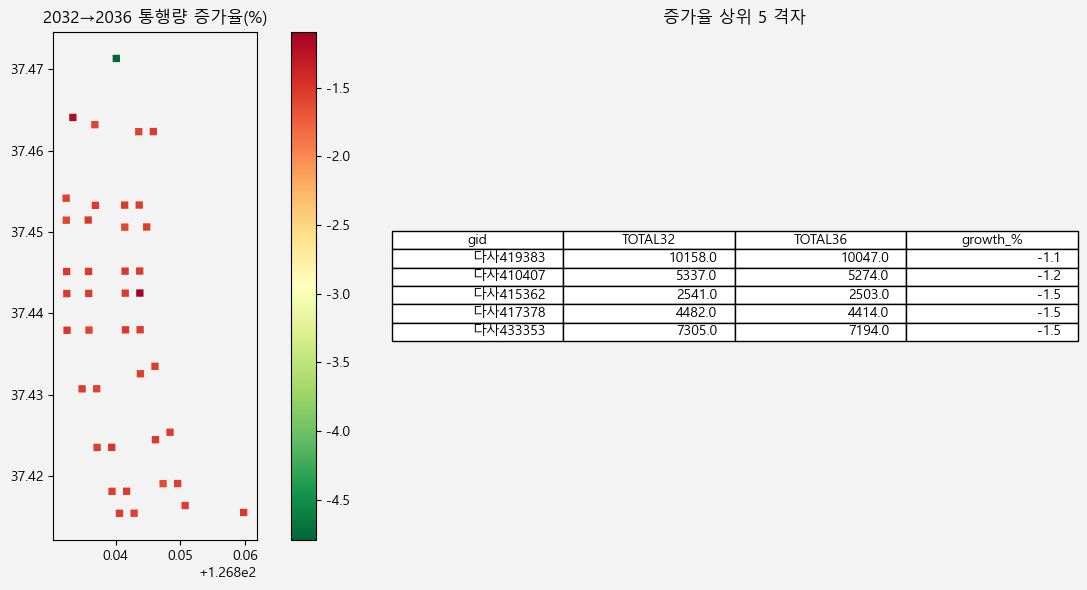

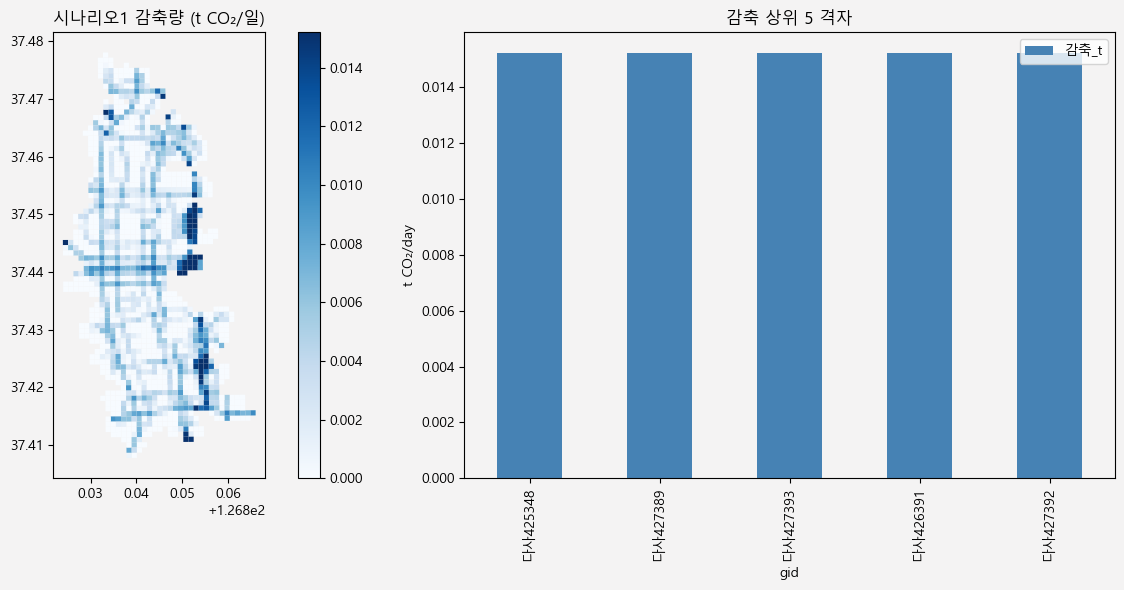

C:\Users\user\AppData\Local\Temp\ipykernel_10032\3797358012.py:59: UserWarning:

Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




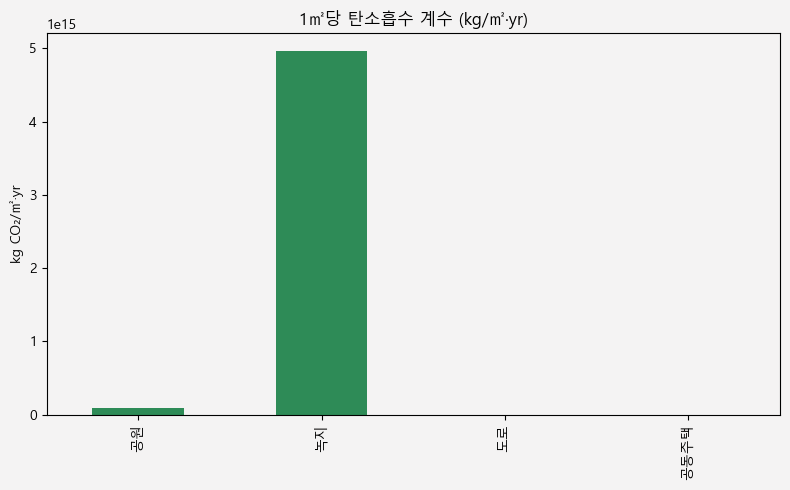

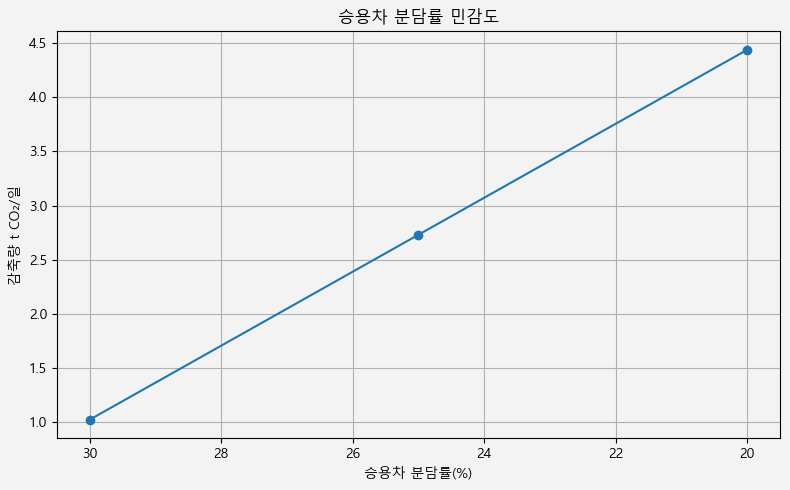

In [159]:
plt.rcParams["figure.figsize"] = (12, 6)

# ---------- utility: load csv safely ----------
def csv_to_gdf(path, crs="EPSG:4326"):
    df = pd.read_csv(path)
    g_cols = [c for c in df.columns if c.lower().startswith('geometry')]
    if not g_cols:
        raise ValueError("geometry column not found")
    geom_col = g_cols[0]
    if len(g_cols) > 1:
        df = df.drop(columns=g_cols[1:])
    if df[geom_col].dtype == object:
        df[geom_col] = df[geom_col].apply(wkt.loads)
    return gpd.GeoDataFrame(df, geometry=geom_col, crs=crs)

# ---------- map 1: 교차로 통행량 증가 비율 ----------
apply['growth_%'] = (apply['TOTAL36'] - apply['TOTAL32']) / apply['TOTAL32'] * 100

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('#f4f3f3')
for a in ax: a.set_facecolor('#f4f3f3')

apply.plot(column='growth_%', cmap='RdYlGn_r', legend=True, ax=ax[0])
ax[0].set_title("2032→2036 통행량 증가율(%)")

top10 = apply[['gid', 'TOTAL32', 'TOTAL36', 'growth_%']].nlargest(5, 'growth_%')
ax[1].axis('off')
tbl = ax[1].table(cellText=top10.round(1).values,
                  colLabels=top10.columns, loc='center')
tbl.auto_set_font_size(False); tbl.set_fontsize(10)
ax[1].set_title("증가율 상위 5 격자")
plt.tight_layout()
plt.show()

# ---------- heatmap 2: 승용차20% 시나리오 감축 ----------
EF = 0.18 / 1000
total_trip = apply['TOTAL36'].sum()
delta_CO2 = (0.33 - 0.20) * total_trip * EF  # t/day
apply['road_w'] = apply['도로'] / apply['도로'].sum()
apply['감축_t'] = apply['road_w'] * delta_CO2

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('#f4f3f3')
for a in ax: a.set_facecolor('#f4f3f3')

apply.plot(column='감축_t', cmap='Blues', legend=True, ax=ax[0])
ax[0].set_title("시나리오1 감축량 (t CO₂/일)")

apply.sort_values('감축_t', ascending=False).head(5).plot.bar(
    x='gid', y='감축_t', ax=ax[1], color='steelblue')
ax[1].set_title("감축 상위 5 격자")
ax[1].set_ylabel("t CO₂/day")
plt.tight_layout()
plt.show()

# ---------- bar 3: 1㎡당 흡수계수 ----------
land_cols = ['공원', '녹지', '도로', '공동주택']
X = apply[land_cols].values
y = np.expm1(apply['예측_탄소흡수량']) / (apply.geometry.area + 1e-6)
model = LinearRegression(fit_intercept=False, positive=True).fit(X, y)
coef = pd.Series(model.coef_, index=land_cols)

fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('#f4f3f3')
ax.set_facecolor('#f4f3f3')

coef.plot.bar(color='seagreen', ax=ax)
ax.set_title("1㎡당 탄소흡수 계수 (kg/㎡·yr)")
ax.set_ylabel("kg CO₂/㎡·yr")
plt.tight_layout()
plt.show()

# ---------- line 4: 민감도 ----------
shares = [0.3, 0.25, 0.2]
reductions = []
for s in shares:
    delta = (0.33 - s) * total_trip * EF
    reductions.append(delta)

fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('#f4f3f3')
ax.set_facecolor('#f4f3f3')

ax.plot([int(x * 100) for x in shares], reductions, marker='o')
ax.invert_xaxis()
ax.set_xlabel("승용차 분담률(%)")
ax.set_ylabel("감축량 t CO₂/일")
ax.set_title("승용차 분담률 민감도")
ax.grid(True)
plt.tight_layout()
plt.show()


In [70]:
# 맵 저장
areaplan_map.save_to_html(file_name="시각화/적용대상지 최종.html")

Map saved to 시각화/적용대상지 최종.html!
